In [1]:
!pip install -U albumentations --quiet
!git clone https://github.com/KuanHaoHuang/AIdea-foot-image-analysis
!ls AIdea-foot-image-analysis/

     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 952kB 19.9MB/s 
     |████████████████████████████████| 37.6MB 108kB/s 
Cloning into 'AIdea-foot-image-analysis'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 1), reused 28 (delta 1), pack-reused 0
Unpacking objects: 100% (32/32), done.
aidea_aso_foot_image_analysis.ipynb		 my_submission.csv
demo						 README.md
image_keypoint_data_augmentation_tutorial.ipynb  sample_train_data
LICENSE						 simple_average_ensemble.R


In [20]:
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import albumentations as A
repo_path = Path("./AIdea-foot-image-analysis")
image_path = repo_path / "sample_train_data/images/"
%matplotlib inline

In [4]:
annotation = pd.read_csv(repo_path / "sample_train_data/annotation.csv")

## 使用 albumentations，Image Data Augmentation 超簡單！
[albumentations](https://github.com/albumentations-team/albumentations) 是一群 Kaggle 大師協力開發的 Python Library，為 Image Data Augmentation 提供簡便操作的 API、以及高效率的運算，其工具包含模糊化、變形、顏色轉換等等，常見的資料增強幾乎都有！


Original Image


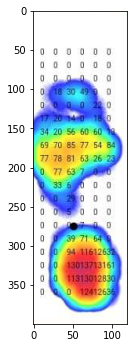


Transformed Image


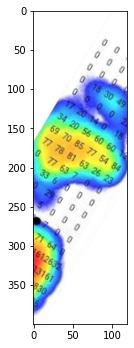

In [ ]:
# albumentations 範例：移動與旋轉

img_name = "image_0001.png"
img = io.imread(image_path / img_name)
print("\nOriginal Image")
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(img)
plt.show()
print("\nTransformed Image")
trafo = A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, value=[255,255,255])
trafo_img = trafo(image=img)['image']
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(trafo_img)
plt.show()

# Keypoints 資料
在本競賽的資料集，除了給你腳部壓力影像、每隻腳還各有 2 個足部標註點資料。圖片上的標註點，英文稱為 Keypoints 或 Landmarks，通常用來標示出圖片上特定資訊的**位置**。

在資料增強時，如果涉及圖片的變形、旋轉、或位移，標註點沒有跟著轉換的話，標示位置就會出錯！

好消息是，albumentations 也提供了讓 Keypoints 與圖片同步資料增強的方便函式。

{'images': 'image_0001.png', 'x1': 55, 'y1': 136, 'x2': 75, 'y2': 383}

Original image


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


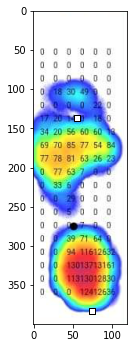


Transformed image, without keypoints transformation


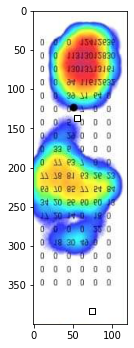


Transformed image and keypoints


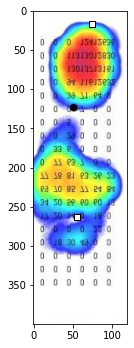

In [ ]:
# albumentations 範例：垂直與水平翻轉

img_name = "image_0001.png"
img = io.imread(image_path / img_name)
annot = annotation[annotation['images']==img_name].to_dict('record')[0]
print(annot)
annot = [annot['x1'], annot['x2']], [annot['y1'], annot['y2']]
print("\nOriginal image")
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(img)
plt.scatter(*annot, s=35, marker='s', c='white', edgecolors='black')
plt.show()
print("\nTransformed image, without keypoints transformation")
trafo = A.Flip(p=1.0)
trafo_img = trafo(image=img)['image']
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(trafo_img)
plt.scatter(*annot, s=35, marker='s', c='white', edgecolors='black')
plt.show()
print("\nTransformed image and keypoints")
trafo = A.Compose([A.Flip(p=1.0)], keypoint_params=A.KeypointParams(format='xy'))
trafo_obj = trafo(image=img, keypoints=list(zip(*annot)))
trafo_img, trafo_keypts = trafo_obj['image'], trafo_obj['keypoints']
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(trafo_img)
plt.scatter(*list(zip(*trafo_keypts)), s=35, marker='s', c='white', edgecolors='black')
plt.show()

# 進階挑戰：不是每個 Augmentation 都可以做到 Keypoints 與 image 同步資料增強
albumentations 有一些資料增強函式是不支援 keypoints 與 image 同步變換的，通常是因為：
* keypoints 不需要變換，例如 Dropout 是在圖片上隨機挖空格增加雜訊，keypoints 位置根本不變，函式當然沒必要支援變換
* keypoints 變換無法精確，例如 ElasticTransform 是讓圖片不規則扭曲變形、圖片與 keypoints 之間的相對位置關係在變換前後難以精確維持
  * ![](https://habrastorage.org/webt/1i/fi/wz/1ifiwzy0lxetc4nwjvss-71nkw0.jpeg)

哪些動作支援 keypoints 變換可以參考 [albumentations 官方文件](https://github.com/albumentations-team/albumentations#spatial-level-transforms)。
                                              
## 就算 albumentations 不支援，也堅持要做 Keypoints 資料增強？翻閱原始碼！
我在比賽中觀察資料後，認為 ElasticTransform 是對本次解題有幫助的資料增強，但是它不支援 keypoints 與 image 同步變換怎麼辦？我採用以下解法：
1. 在 [albumentations 的原始碼](https://github.com/albumentations-team/albumentations/blob/95a048d342cbe748e5acf15cb1a28611a6303885/albumentations/augmentations/geometric/functional.py#L191) 中找到，進行變換的原理其實是 opencv 的仿射變換+每個像素隨機偏移
2. 將 keypoints 以矩陣表示，也進行仿射變換，取出「最接近」的變換後結果 keypoints

{'images': 'image_0001.png', 'x1': 55, 'y1': 136, 'x2': 75, 'y2': 383}

Original Image


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


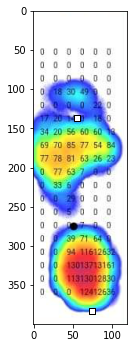


Augmented Image and keypoints


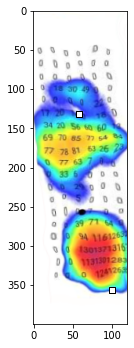

In [54]:
# 範例：ElasticTransform

img_name = "image_0001.png"
img = io.imread(image_path / img_name)
annot = annotation[annotation['images']==img_name].to_dict('record')[0]
print(annot)

RANDOM_SEED = 52
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 以矩陣形式表示兩個 keypoints 位置
mask1 = np.zeros((*img.shape[:2], 1))
mask1[int(annot['y1']), int(annot['x1'])] = 1
mask2 = np.zeros((*img.shape[:2], 1))
mask2[int(annot['y2']), int(annot['x2'])] = 1

# 設定仿射變換參數
height, width = img.shape[:2]
center_square = np.float32((height, width)) // 2
square_size = min((height, width)) // 3
pts1 = np.float32(
    [
        center_square + square_size,
        [center_square[0] + square_size, center_square[1] - square_size],
        center_square - square_size,
    ]
)
alpha_affine = float(random.random()*5)
pts2 = pts1 + np.random.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
matrix = cv2.getAffineTransform(pts1, pts2)

random_state = np.random.RandomState(None)
alpha = 80
sigma = 8
dx = np.float32(gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma) * alpha)
dy = np.float32(gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma) * alpha)
x, y = np.meshgrid(np.arange(width), np.arange(height))
map_x = np.float32(x + dx)
map_y = np.float32(y + dy)
 

print("\nOriginal Image")
plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(img)
plt.scatter([annot['x1'], annot['x2']], [annot['y1'], annot['y2']], s=35, marker='s', c='white', edgecolors='black')
plt.show()
print("\nAugmented Image and keypoints")
trafo_img = cv2.warpAffine(img,
            M=matrix, dsize=(width, height), 
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
        )
trafo_img = cv2.remap(trafo_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderValue= 0, borderMode=cv2.BORDER_REFLECT_101)
trafo_mask1 = cv2.warpAffine(mask1,
            M=matrix, dsize=(width, height), 
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
        )
trafo_mask1 = cv2.remap(trafo_mask1, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderValue= 0, borderMode=cv2.BORDER_REFLECT_101)
trafo_mask2 = cv2.warpAffine(mask2,
            M=matrix, dsize=(width, height), 
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)
        )
trafo_mask2 = cv2.remap(trafo_mask2, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderValue= 0, borderMode=cv2.BORDER_REFLECT_101)

mask1_y, mask1_x = np.where(trafo_mask1)[0].mean(), np.where(trafo_mask1)[1].mean()
mask2_y, mask2_x = np.where(trafo_mask2)[0].mean(), np.where(trafo_mask2)[1].mean()

plt.figure(figsize = (6.4*1.2,4.8*1.2))
plt.imshow(trafo_img)
plt.scatter([mask1_x, mask2_x], [mask1_y, mask2_y], s=35, marker='s', c='white', edgecolors='black')
plt.show()